# PV Rooftop - Buildings

This notebook is an example about how to access the PV rooftop dataset named *buildings* through OEDI data lake.

## 0. Prerequisites

To run this example, it requires you have OEDI data lake deployed, where all quries run through. About how to deploy OEDI data lake, please refer to the documentation here - https://openedi.github.io/open-data-access-tools/.

In this example, the deployed database is `oedi_data_lake`, where the table related to *buildings* dataset is named `pv_rooftop_buildings`, the staging location for queries is `s3://nrel-tests`.

In [1]:
database_name = "oedi_pv_rooftops"
table_name = "pv_rooftop_aspects"
staging_location = "s3://nrel-tests/"

## 1. Buildings Metadata
In oedi, the `OEDIGlue` class provides utility methods to retrieve the metadata from the database, where the metadata includes `Columns`, `Partition Keys`, and `Partition Values`.

In [2]:
from oedi.AWS.glue import OEDIGlue

In [3]:
glue = OEDIGlue()

In [4]:
# Table Column Definition
glue.get_table_columns(database_name, table_name)

Name    Type
0             gid  bigint
1            city  string
2           state  string
3            year  bigint
4        bldg_fid  bigint
5          aspect  bigint
6  the_geom_96703  string
7   the_geom_4326  string

In [5]:
# Table Parition Keys
glue.get_partition_keys(database_name, table_name)

Name    Type
0  city_year  string

In [6]:
# Table Partition Values
glue.get_partition_values(database_name, table_name)

['omaha_ne_07',
 'syracuse_ny_08',
 'dayton_oh_12',
 'palmbay_fl_10',
 'pittsburgh_pa_12',
 'desmoines_ia_10',
 'elpaso_tx_07',
 'springfield_il_09',
 'saltlakecity_ut_12',
 'denver_co_12',
 'helena_mt_07',
 'minneapolis_mn_07',
 'indianapolis_in_12',
 'sanantonio_tx_08',
 'charlotte_nc_06',
 'dover_de_09',
 'lasvegas_nv_09',
 'columbus_oh_12',
 'indianapolis_in_06',
 'bakersfield_ca_10',
 'ftbelvoir_dc_12',
 'jacksonville_fl_10',
 'omaha_ne_13',
 'santafe_nm_09',
 'chicago_il_12',
 'flint_mi_09',
 'laguardiajfk_ny_07',
 'louisville_ky_06',
 'shreveport_la_08',
 'missionviejo_ca_13',
 'stlouis_mo_08',
 'worcester_ma_09',
 'hartford_ct_13',
 'washington_dc_12',
 'bridgeport_ct_06',
 'albuquerque_nm_12',
 'helena_mt_13',
 'tulsa_ok_08',
 'batonrouge_la_06',
 'scranton_pa_08',
 'springfield_ma_07',
 'stockton_ca_10',
 'carsoncity_nv_09',
 'oklahomacity_ok_13',
 'buffalo_ny_08',
 'kansascity_mo_12',
 'olympia_wa_10',
 'spokane_wa_08',
 'boulder_co_14',
 'mobile_al_10',
 'baltimore_md_13',


## 2. Run Query
Based on the metadata retrieved above, we can query data by using method in `OEDIAthena` class. In the example below, we select records from partition `topeka_ks_08`.

In [7]:
from pyproj import CRS
from oedi.AWS.athena import OEDIAthena

In [8]:
athena = OEDIAthena(staging_location="s3://nrel-tests", region_name="us-west-2")

In [9]:
query_string = f"""
    SELECT gid, bldg_fid, the_geom_4326
    FROM {database_name}.{table_name}
    WHERE city_year='topeka_ks_08'
"""
gdf = athena.run_query(query_string, geometry="the_geom_4326")

In [10]:
gdf.crs = CRS("EPSG:4326")

In [11]:
gdf

gid  bldg_fid                                      the_geom_4326
0       621582     18386  MULTIPOLYGON (((-95.68506 39.01188, -95.68506 ...
1       621583     18378  MULTIPOLYGON (((-95.68484 39.01188, -95.68485 ...
2       621588     18274  MULTIPOLYGON (((-95.65377 39.01259, -95.65378 ...
3       621589     18305  MULTIPOLYGON (((-95.65132 39.01265, -95.65135 ...
4       621590     18249  MULTIPOLYGON (((-95.64810 39.01272, -95.64811 ...
...        ...       ...                                                ...
853864  621567     18308  MULTIPOLYGON (((-95.70404 39.01144, -95.70405 ...
853865  621568     18302  MULTIPOLYGON (((-95.70177 39.01149, -95.70178 ...
853866  621569     18310  MULTIPOLYGON (((-95.70122 39.01150, -95.70125 ...
853867  621586     18201  MULTIPOLYGON (((-95.65775 39.01250, -95.65776 ...
853868  621587     18231  MULTIPOLYGON (((-95.65537 39.01256, -95.65537 ...

[853869 rows x 3 columns]

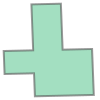

In [12]:
# Check geometry
geom = gdf.iloc[1]["the_geom_4326"]
geom

## 3. Building Visualization

To visualize the buildings of PV rooftops on map, and check its geographic distribution.

In [13]:
import folium
import plotly.graph_objs as go

In [14]:
# Sample datasets, otherwise datasets is too large to show.
samples = gdf.sample(n=10000)

In [15]:
imap = folium.Map(location=[39.0473, -95.6752], zoom_start=11, tiles="Stamen Toner")

# Style function
def style_function(feature):
    return {
        "fillOpacity": 0.75,
        "fillColor": "#00bfff",
        "wight": 0.1,
        "color": "#00bfff"
    }

# GeoJSON
folium.GeoJson(
    name="PV Rooftops",
    data=samples.to_json(),
    style_function=style_function
).add_to(imap)

imap